In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from scripts.utils.cheby_shev import ChebConv

In [2]:
nside = 512
order = 4

In [3]:
def nside2index(nside, order):
    nsample = 12 * order**2
    indexes = np.arange(hp.nside2npix(nside) // nsample)
    return indexes

In [4]:
def patch_index_wneighbor(nside, order):
    indexes = list(nside2index(nside, order))
    neighbors = hp.pixelfunc.get_all_neighbours(nside, indexes, nest=True)
    neighbors = np.unique(neighbors.reshape(-1))
    nei_patch = np.setdiff1d(neighbors, indexes)
    return nei_patch

In [5]:
l_nei_patch = {}
for i in range(np.log2(nside).astype(int)):
    tmp_patch_size = hp.nside2npix(nside)//hp.nside2npix(2**i)
    l_nei_patch[tmp_patch_size] = len(patch_index_wneighbor(nside, 2**i))

In [6]:
print(hp.nside2npix(nside)//hp.nside2npix(2**8))

4


In [7]:
print(l_nei_patch)

{262144: 2051, 65536: 1028, 16384: 516, 4096: 260, 1024: 132, 256: 68, 64: 36, 16: 20, 4: 12}


In [8]:
class SphericalChebConv_pad(nn.Module):
    def __init__(self, in_channels, out_channels, lap, pad_size, kernel_size):
        super().__init__()
        self.register_buffer("laplacian", lap)
        self.pad_size = pad_size
        self.paddding = nn.ConstantPad1d(padding=(0,pad_size), value=0)
        self.chebconv = ChebConv(in_channels, out_channels, kernel_size)

    def state_dict(self, *args, **kwargs):
        state_dict = super().state_dict(*args, **kwargs)
        del_keys = []
        for key in state_dict:
            if key.endswith("laplacian"):
                del_keys.append(key)
        for key in del_keys:
            del state_dict[key]
        return state_dict

    def forward(self, x):
        x = self.paddding(x)
        x = self.chebconv(self.laplacian, x)
        x = x[:, :-self.pad_size, :]
        return x

In [12]:
sample_map = hp.read_map("/gpfs02/work/akira.tokiwa/gpgpu/FastPM/healpix/nc128/map_nc128_nside512_12659.fits")

In [256]:
nside = 128
npix = hp.nside2npix(nside)
masked1 = np.zeros(npix, dtype=np.int64)

orders = [1, 2, 4, 8, 16]
patch_nums = [12 * order**2 for order in orders]
patch_idx = [npix//patch_num for patch_num in patch_nums]
for i in range(patch_nums[0]):
    masked1[i*patch_idx[0]:(i+1)*patch_idx[0]] = -i

In [257]:

clist = [format(i, f'0{len(orders)}b') for i in range(2**(len(orders)-1))]
def decode_right(coef, patch_idx, base_idx):
    # x: binary string
    # output: patch index
    x = np.array([2 if i == "1" else 0 for i in coef])
    return base_idx + np.sum(x * patch_idx)

def decode_left(coef, patch_idx, base_idx):
    # x: binary string
    # output: patch index
    x = np.array([2 if i == "1" else 0 for i in coef])
    return base_idx + np.sum(x * patch_idx)

In [258]:
def paint_idx(clist, patch_idx, base_idx):
    idx_list = []
    for coef in clist:
        idx_list.append(decode_right(coef, patch_idx, base_idx))
    return idx_list

In [259]:
base_idx = npix//2
paint_list = paint_idx(clist, patch_idx, base_idx)
for i in range(len(paint_list)):
    if i == 0:
        overlap_start, overlap_end = base_idx, base_idx + 2 * patch_idx[-1]
    else:
        overlap_start, overlap_end = paint_list[i-1],  paint_list[i-1] + 2 * patch_idx[-1]
    gen_start, gen_end = paint_list[i], paint_list[i] + 2 * patch_idx[-1]
    masked1[gen_start:gen_end] = i + 4
    masked1[overlap_start:overlap_end] = i + 4

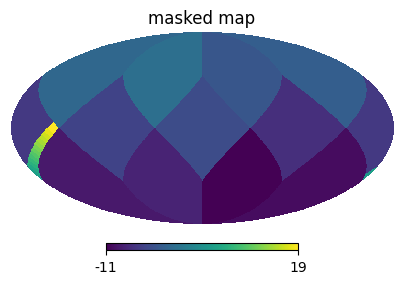

In [260]:
fig = plt.figure(figsize=(4,4))
hp.mollview(masked1, nest=True, fig=fig.number, title="masked map")

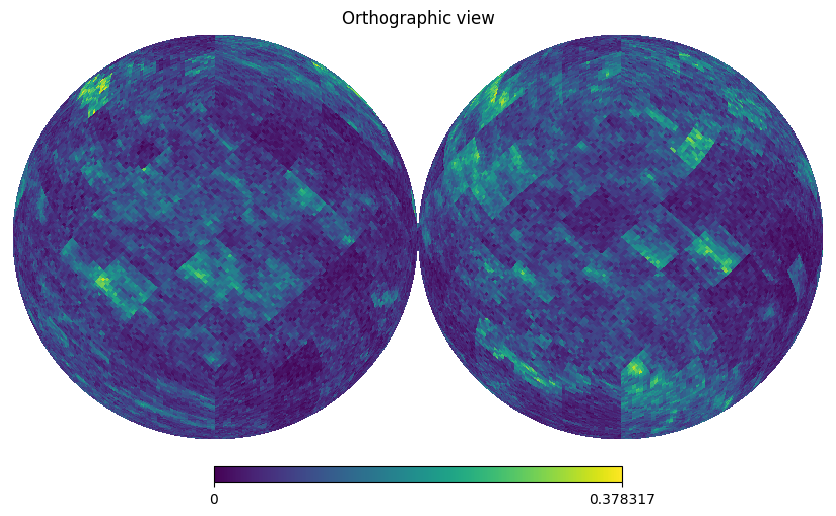

In [61]:
hp.orthview(sample_map, nest=True)